In [1]:
## Parameters specific to where your folders are and your data
parameter_file = '../params/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
anno_gff=doc['annotation']
mRNA_peak_file = doc["mRNA_peak_file"]

tss_annotation = doc['tss_annotation']


import os
from os.path import join
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
from tqdm import *
from os.path import basename
##mpl.use('Agg')
#mpl.style.use('ggplot')
#mpl.style.use('fivethirtyeight')
from Homer import *
import helper
import create_output
print('Number of tissues: ',len(tissues))

from collections import Counter


('Number of tissues: ', 13)


## File and folder names. 
(input is bam files, and design csv file)

In [2]:
bed_f = "../Results/output/TSS1.exp.bed"

In [3]:
epi_hist_dir = "Results/epigenome"
if not os.path.exists(epi_hist_dir):
    os.mkdir(epi_hist_dir)

In [ ]:
chip_dir = os.path.join(data_folder,"external", "Sequencing", "PRJEB9291","processed")
bam_dir = os.path.join(chip_dir,"sortBam")
tag_dir = os.path.join(chip_dir, "tagDir")
peak_dir = os.path.join(chip_dir, "peaksDir")
bam_files = glob.glob(bam_dir + "/*bam")

design = pd.read_csv(os.path.join(chip_dir, "design.csv"))
design["ID"] = design["fastq_1"].apply(lambda x: x.replace(".fastq.gz",""))
design = design[~(design["group"] == "#Input")]
design

group  replicate              fastq_1 fastq_2  antibody control  \
0  H3K27Ac          1  ERS2502089.fastq.gz      Ac     Input     NaN   
1  H3K27Ac          2  ERS2502088.fastq.gz      Ac    Input      NaN   
2  H3K9me3          1  ERS2502102.fastq.gz     NaN   H3K9me3   Input   
3  H3K9me3          2  ERS2502103.fastq.gz     NaN  H3K9me3    Input   
4  H3K4me3          1  ERS2502074.fastq.gz     NaN   H3K4me3   Input   
5  H3K4me3          2  ERS2502075.fastq.gz     NaN   H3K4me3   Input   
6    Input          1   ERS715556.fastq.gz     NaN       NaN     NaN   
7    Input          2   ERS715572.fastq.gz     NaN       NaN     NaN   
8    Input          3   ERR868163.fastq.gz     NaN       NaN     NaN   

           ID  
0  ERS2502089  
1  ERS2502088  
2  ERS2502102  
3  ERS2502103  
4  ERS2502074  
5  ERS2502075  
6   ERS715556  
7   ERS715572  
8   ERR868163

annotatePeaks.pl ../Results/output/TSS1.exp.bed /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 4000 -hist 25 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/external/Sequencing/PRJEB9291/processed/tagDir/ERS2502089_1 -pc 3 > Results/epigenome/ERS2502089_1_hist
annotatePeaks.pl ../Results/output/TSS1.exp.bed /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 4000 -hist 25 -histNorm 100 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/external/Sequencing/PRJEB9291/processed/tagDir/ERS2502089_1 -pc 3 > Results/epigenome/ERS2502089_1_histNorm
annotatePeaks.pl ../Results/output/TSS1.exp.bed /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 4000 -

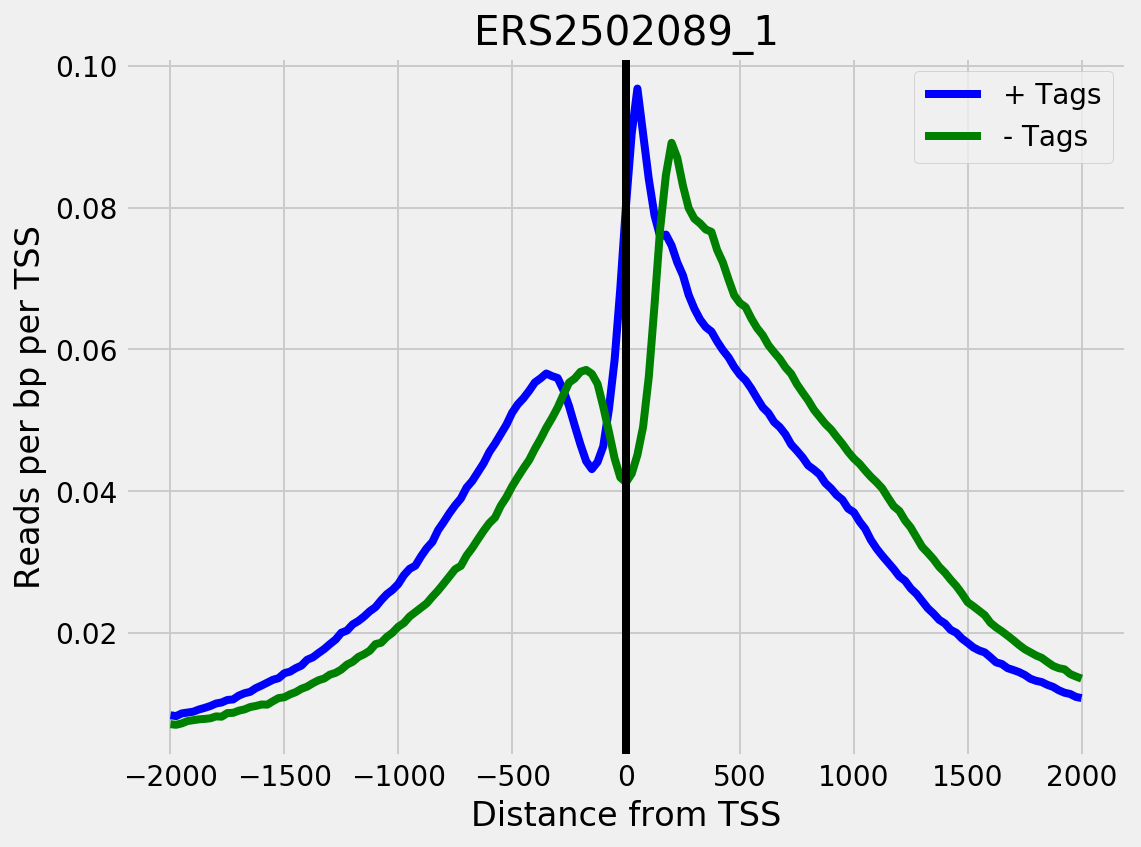

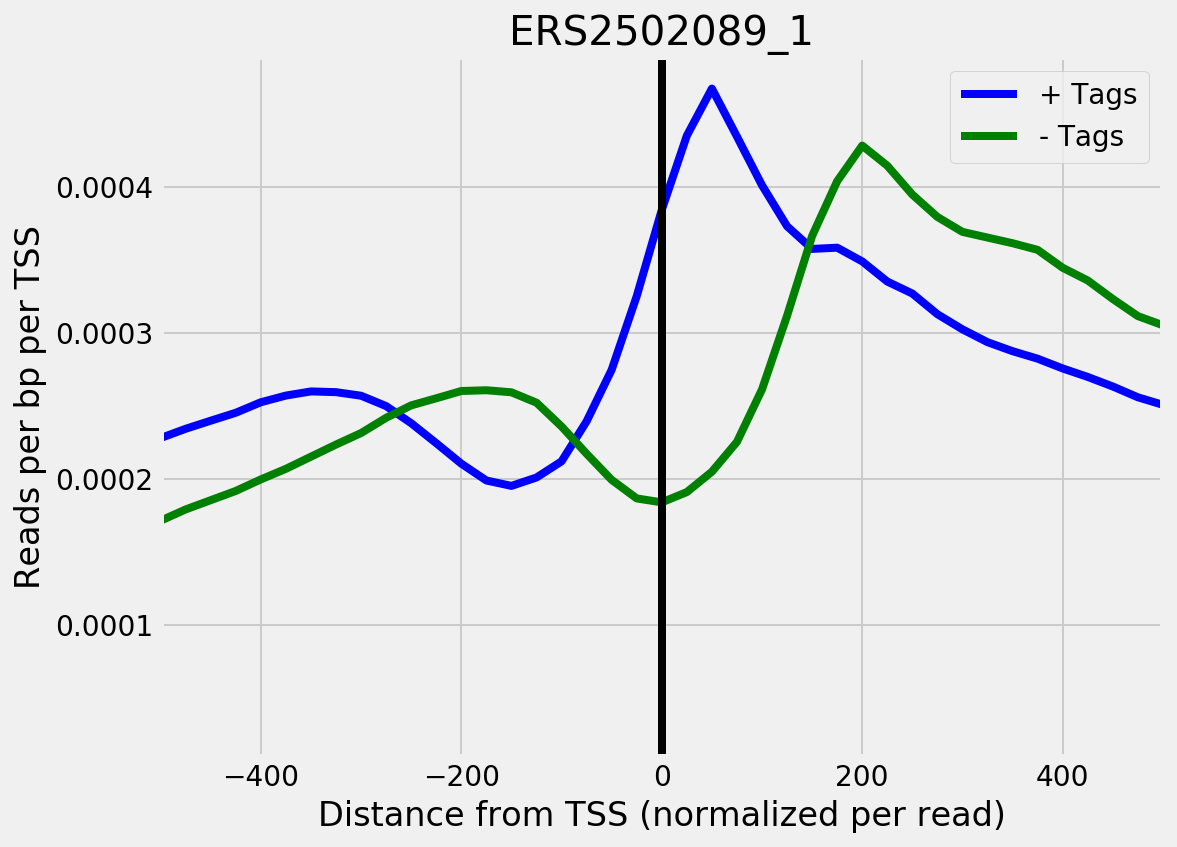

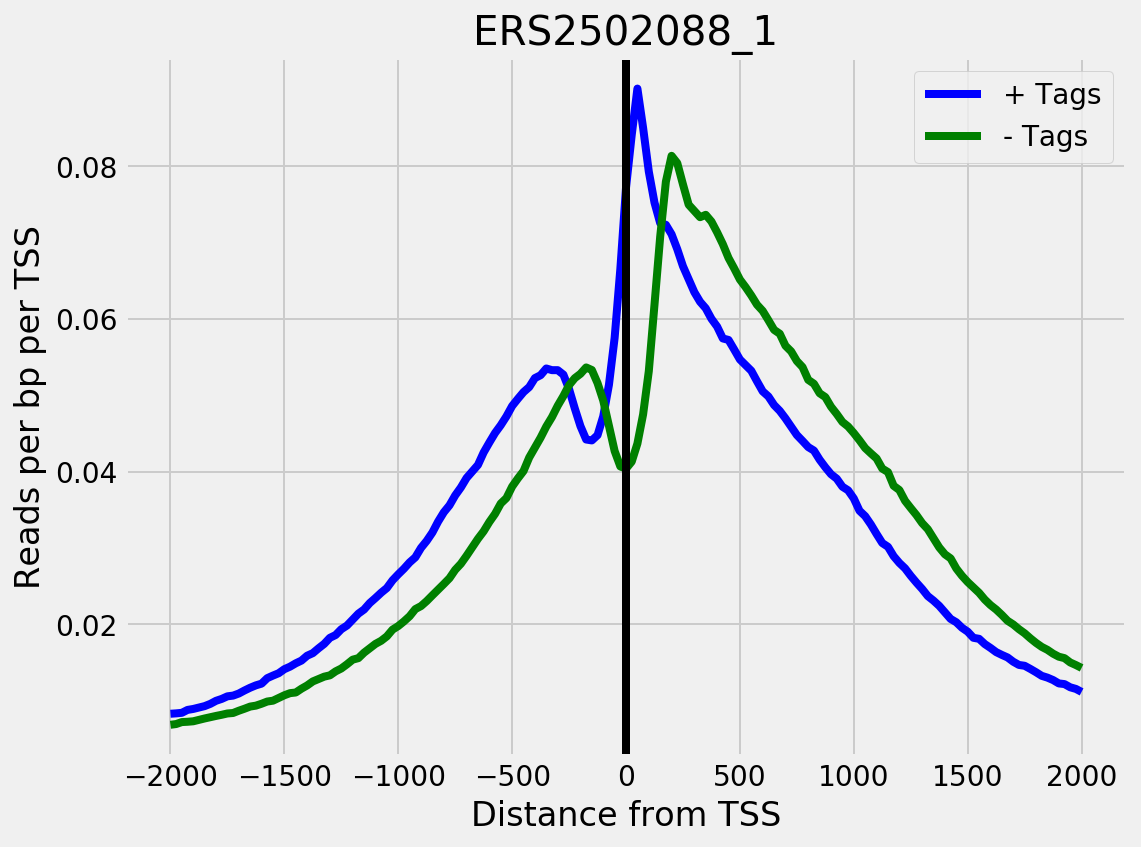

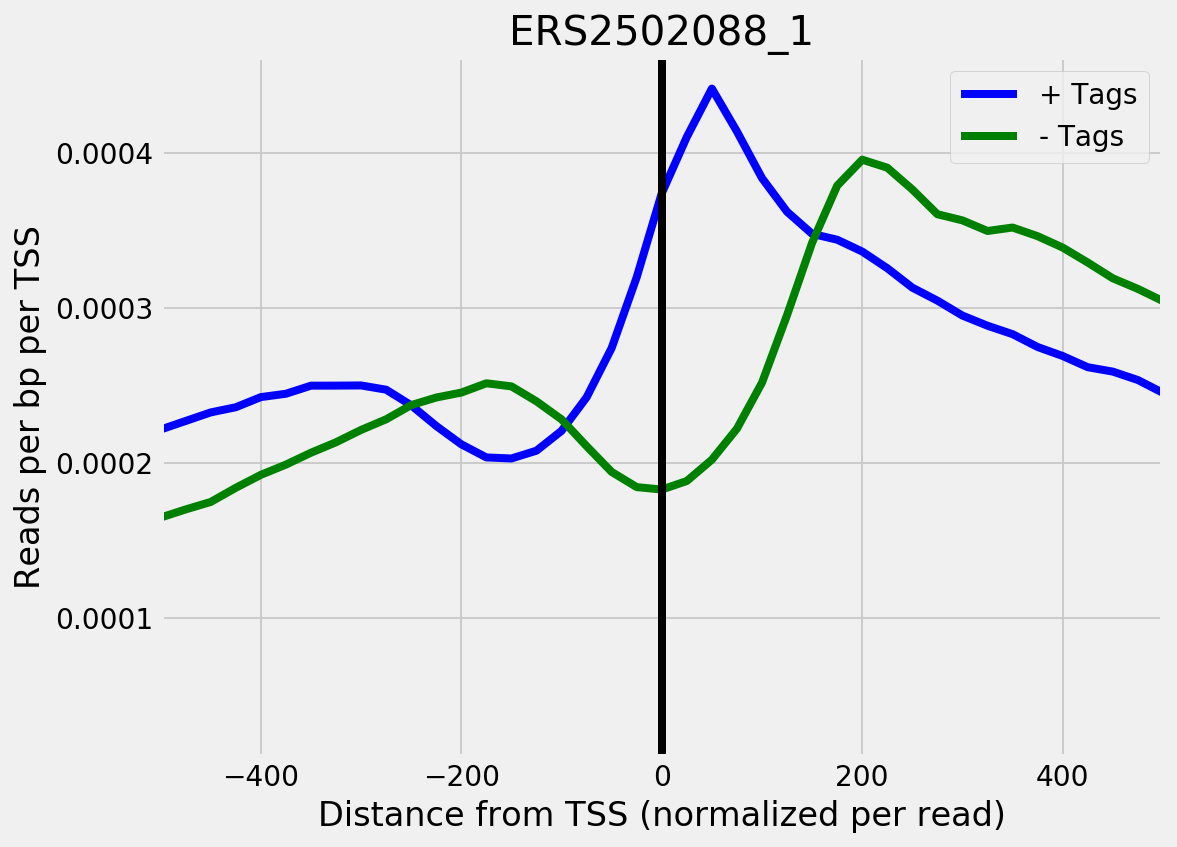

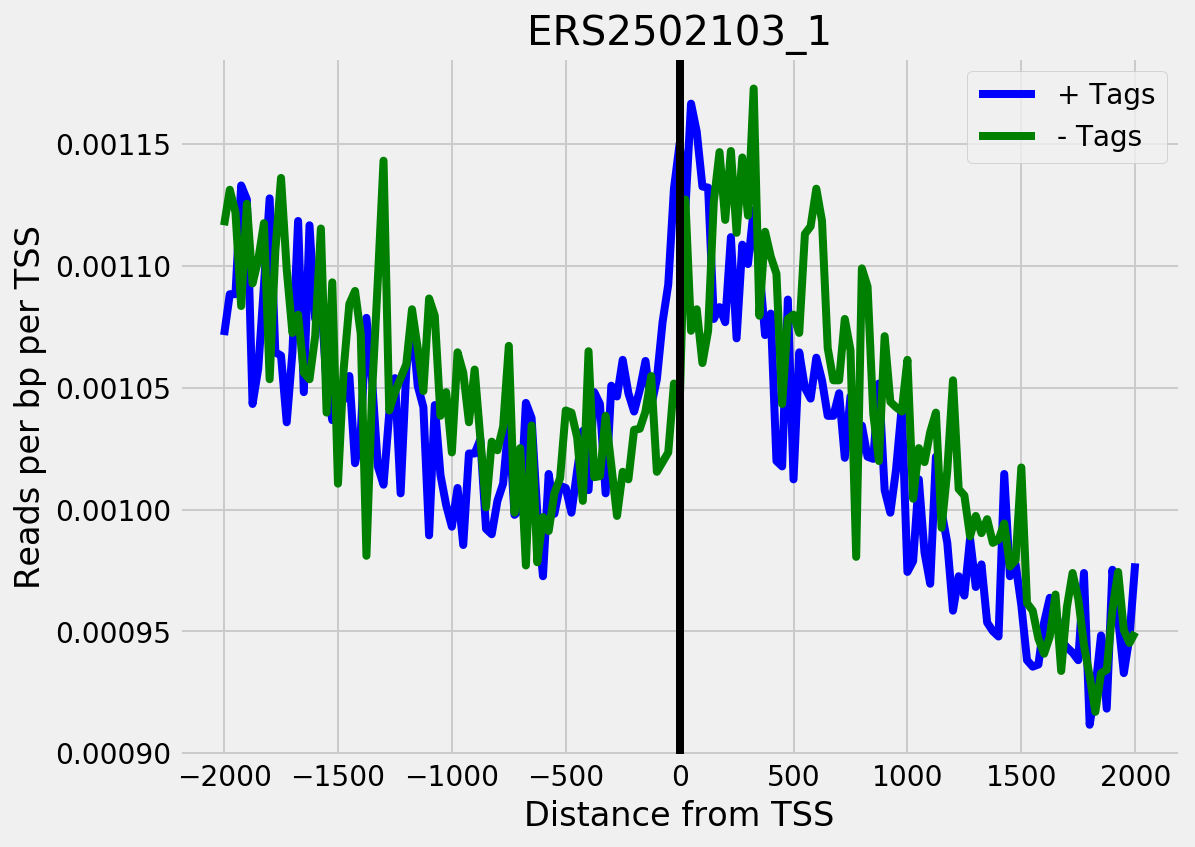

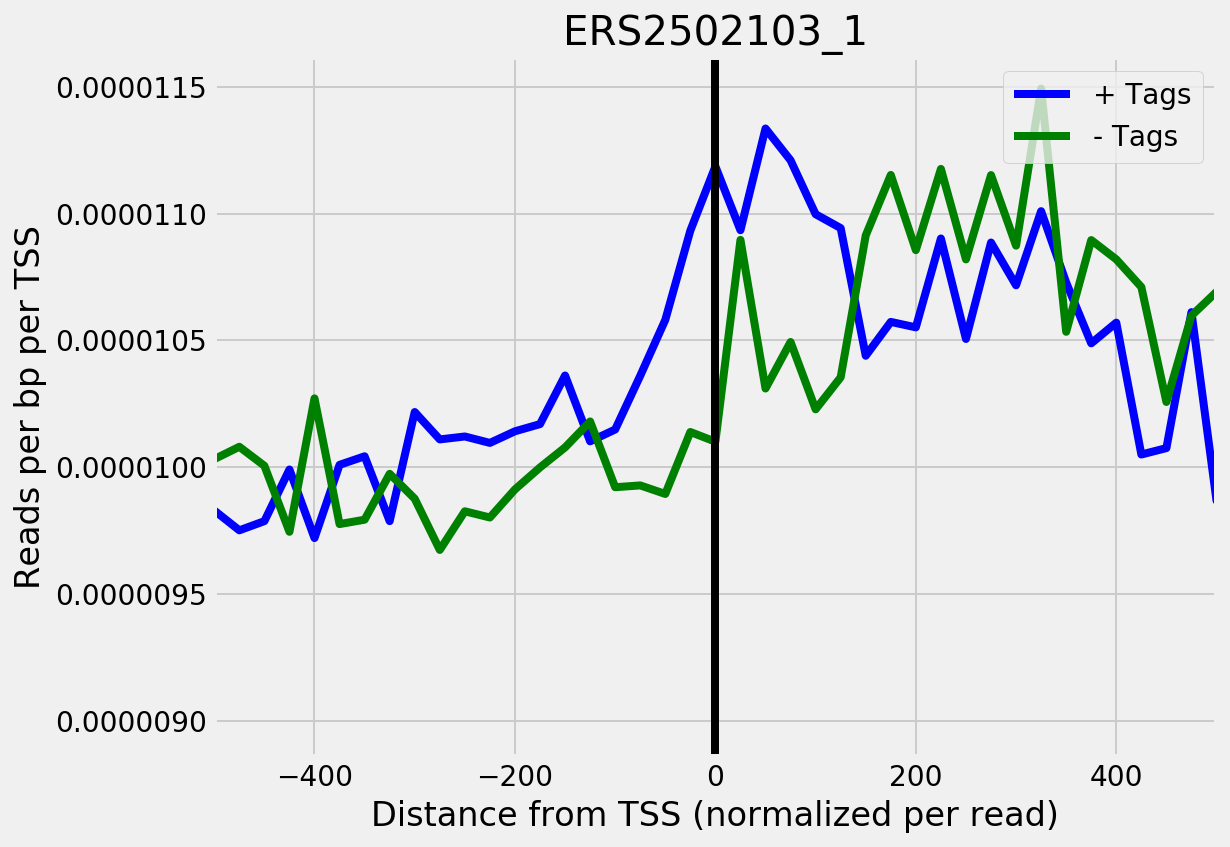

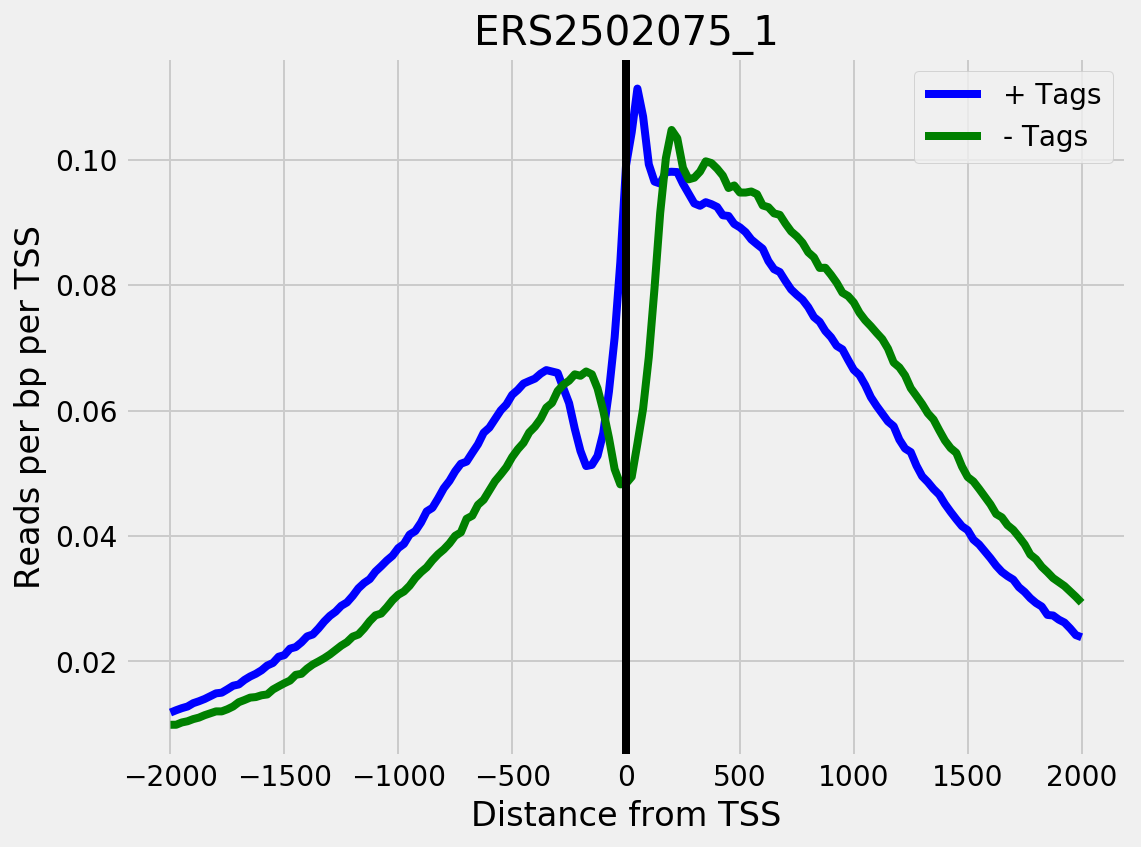

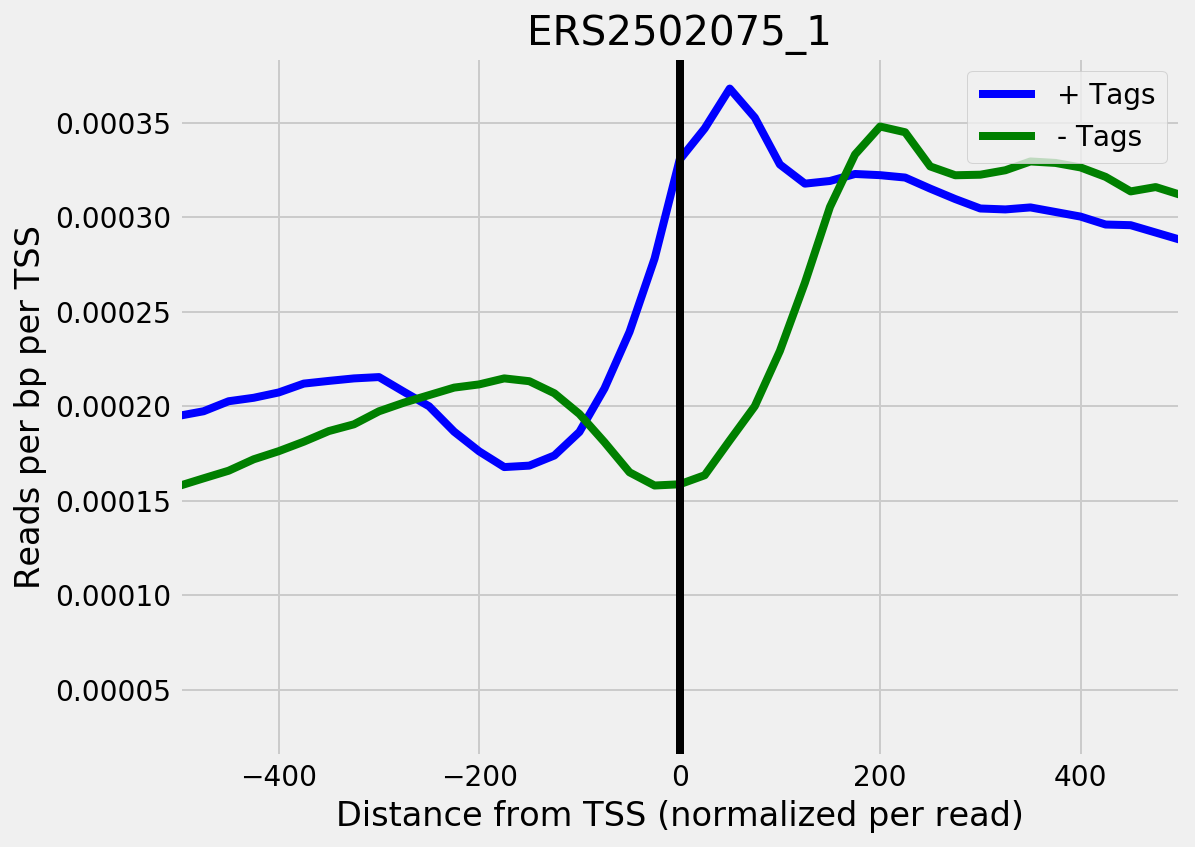

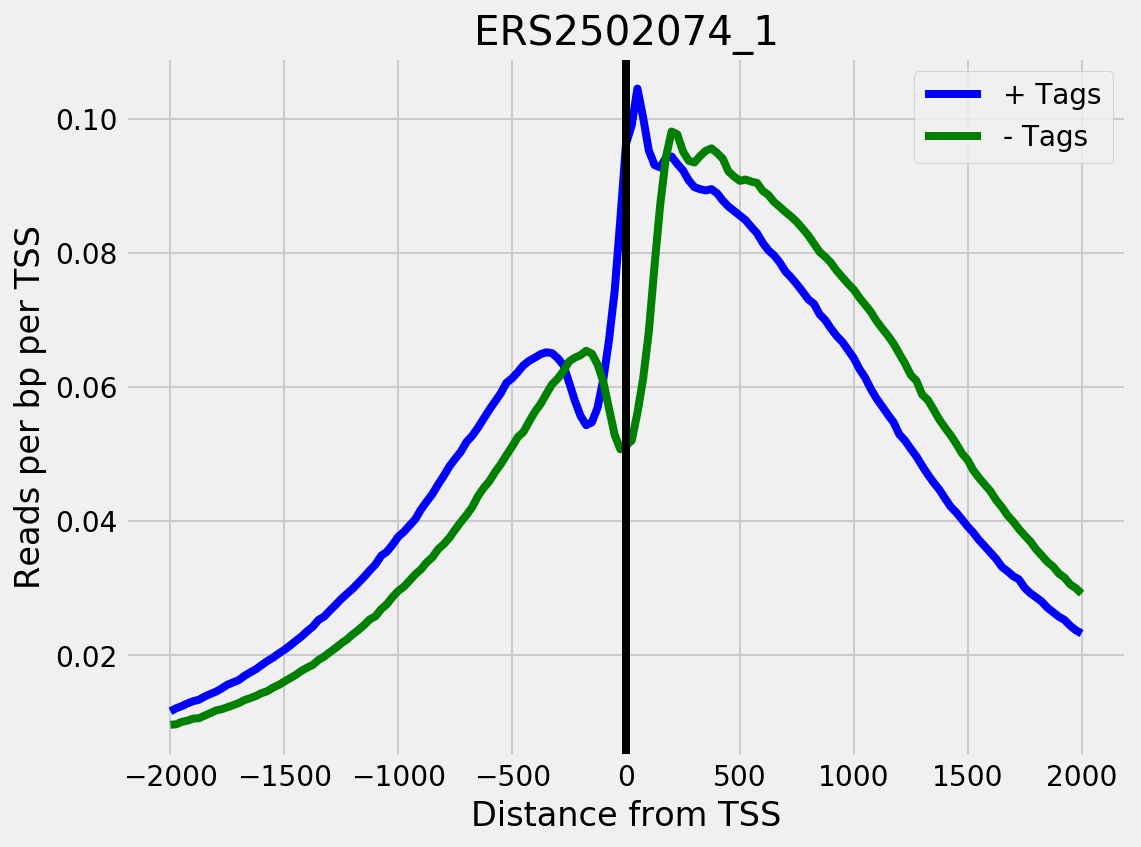

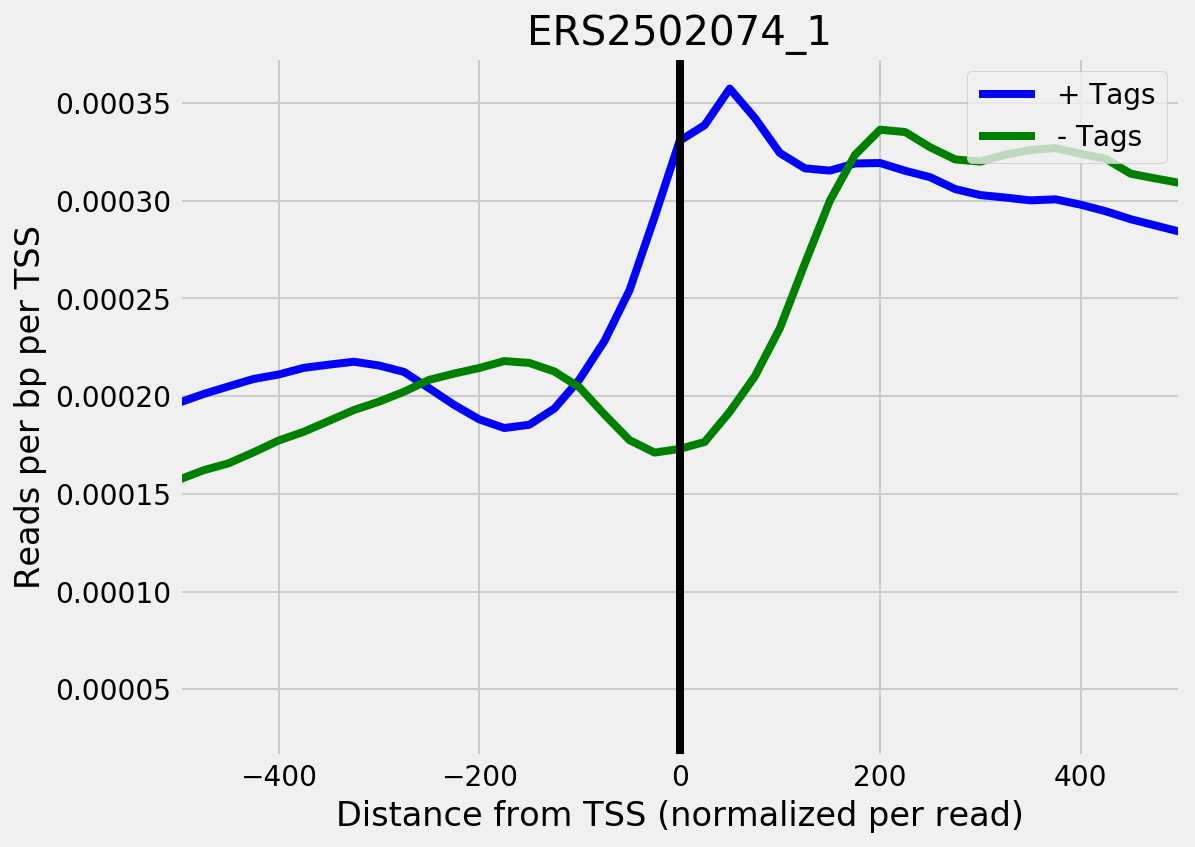

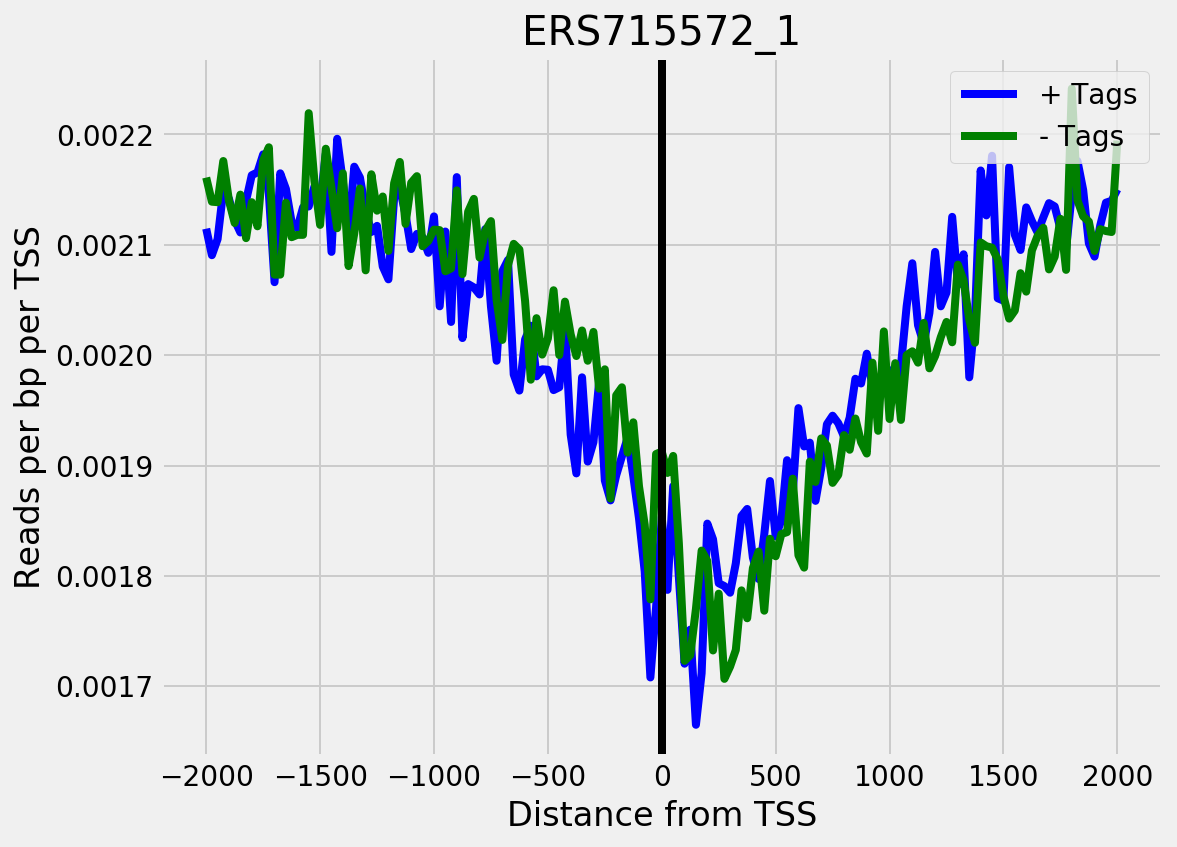

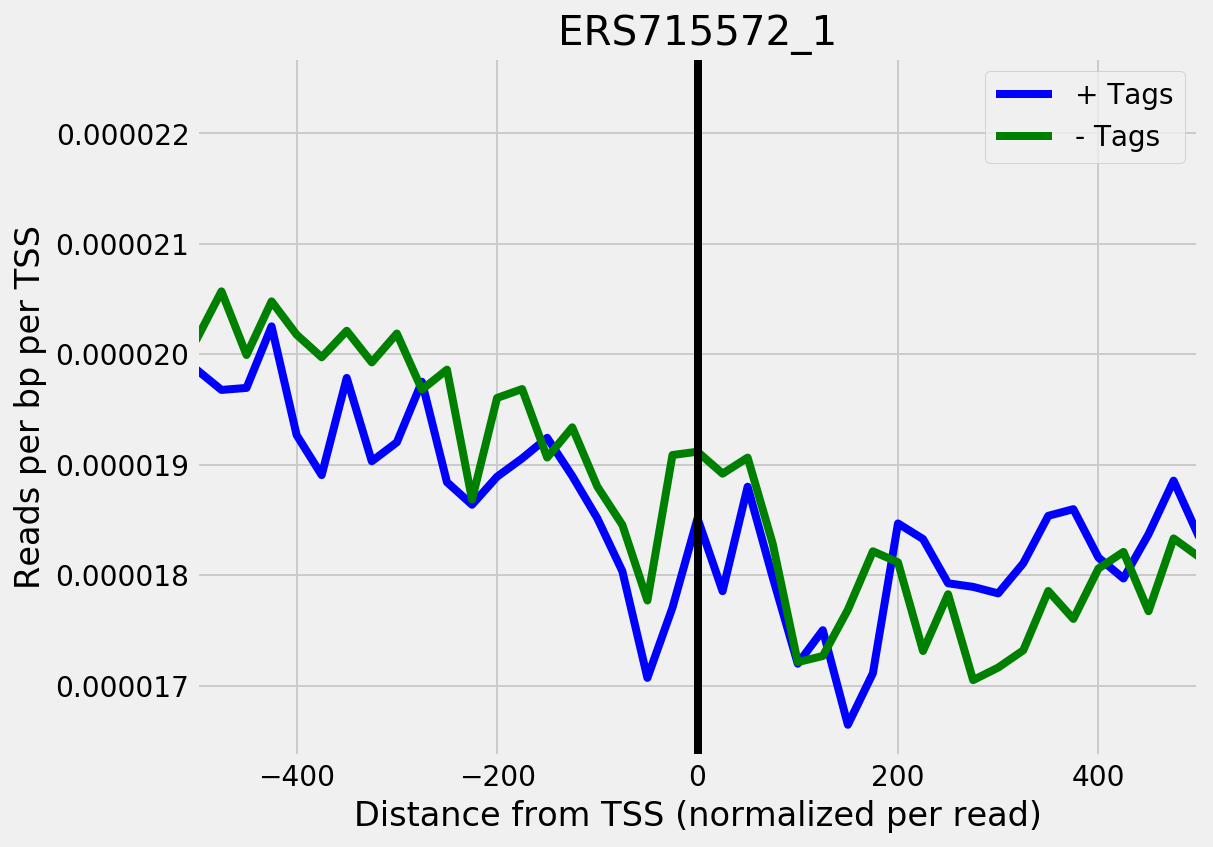

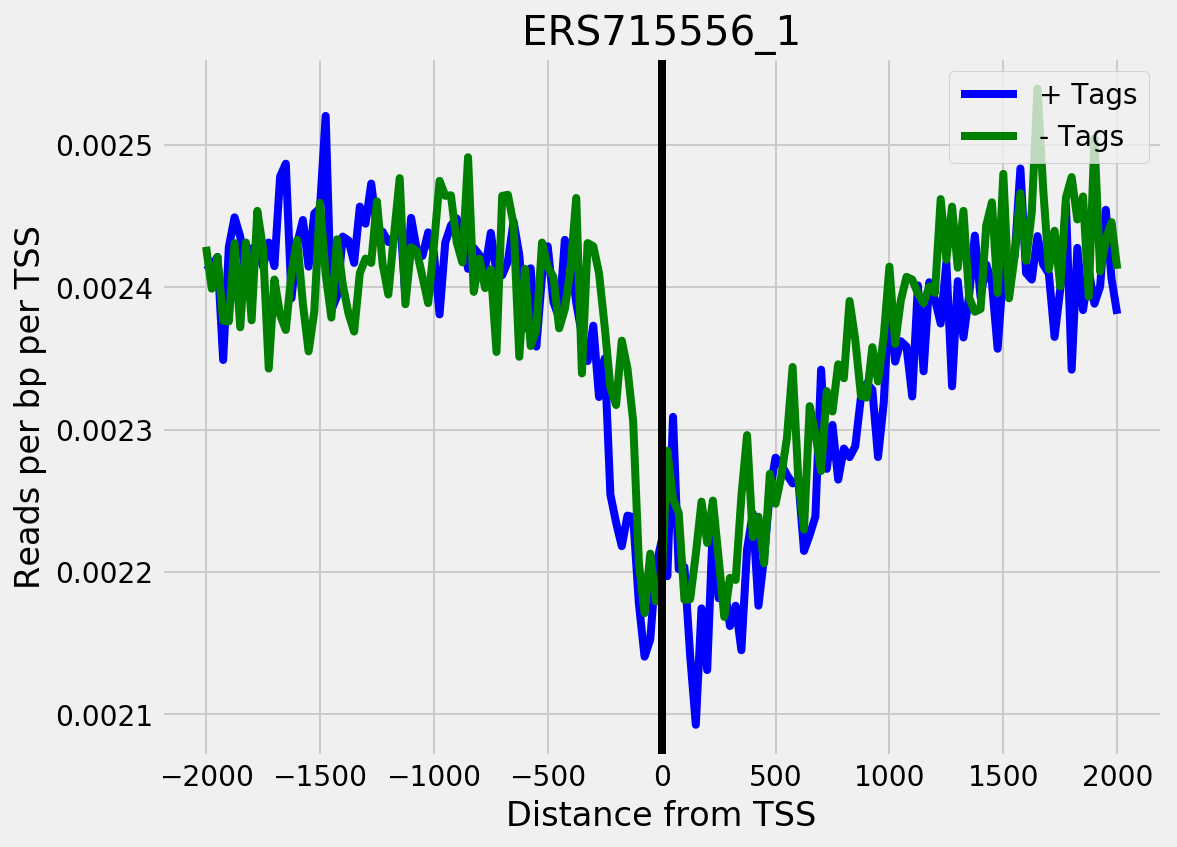

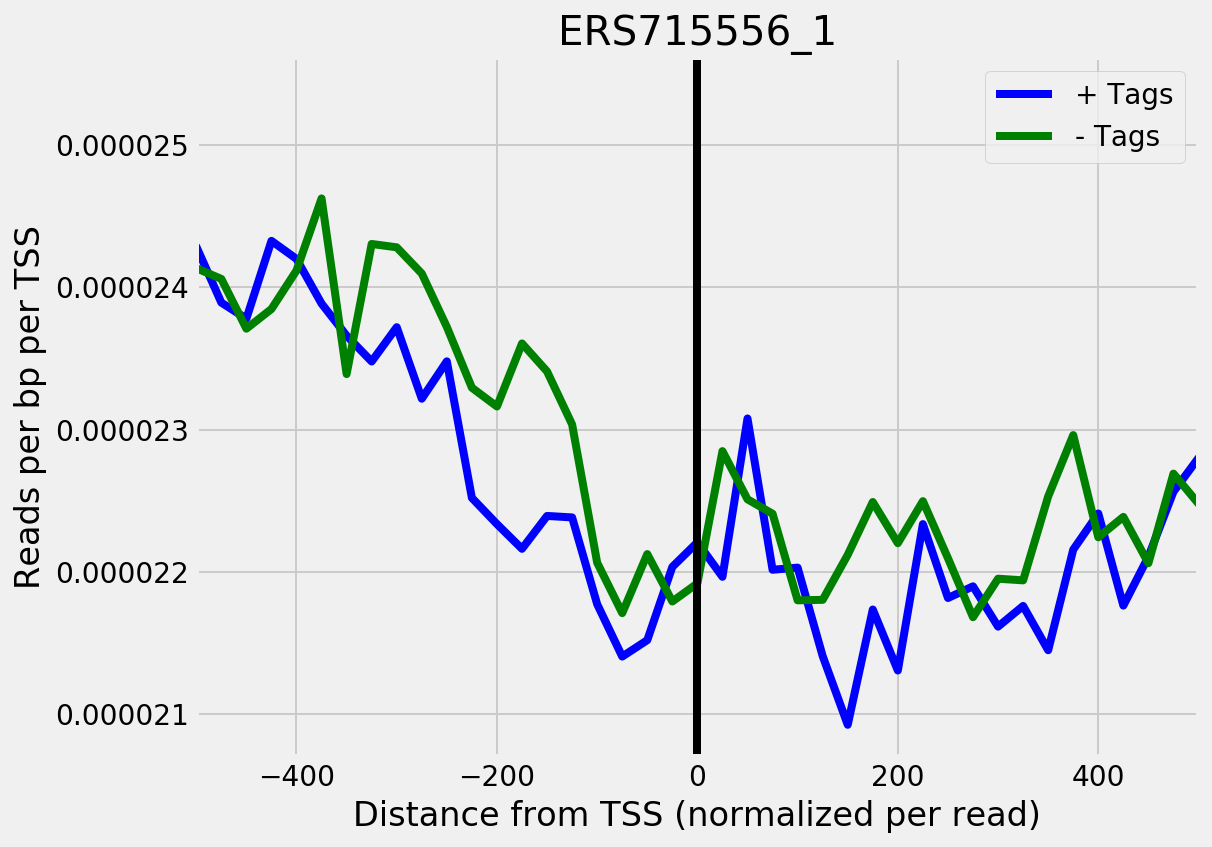

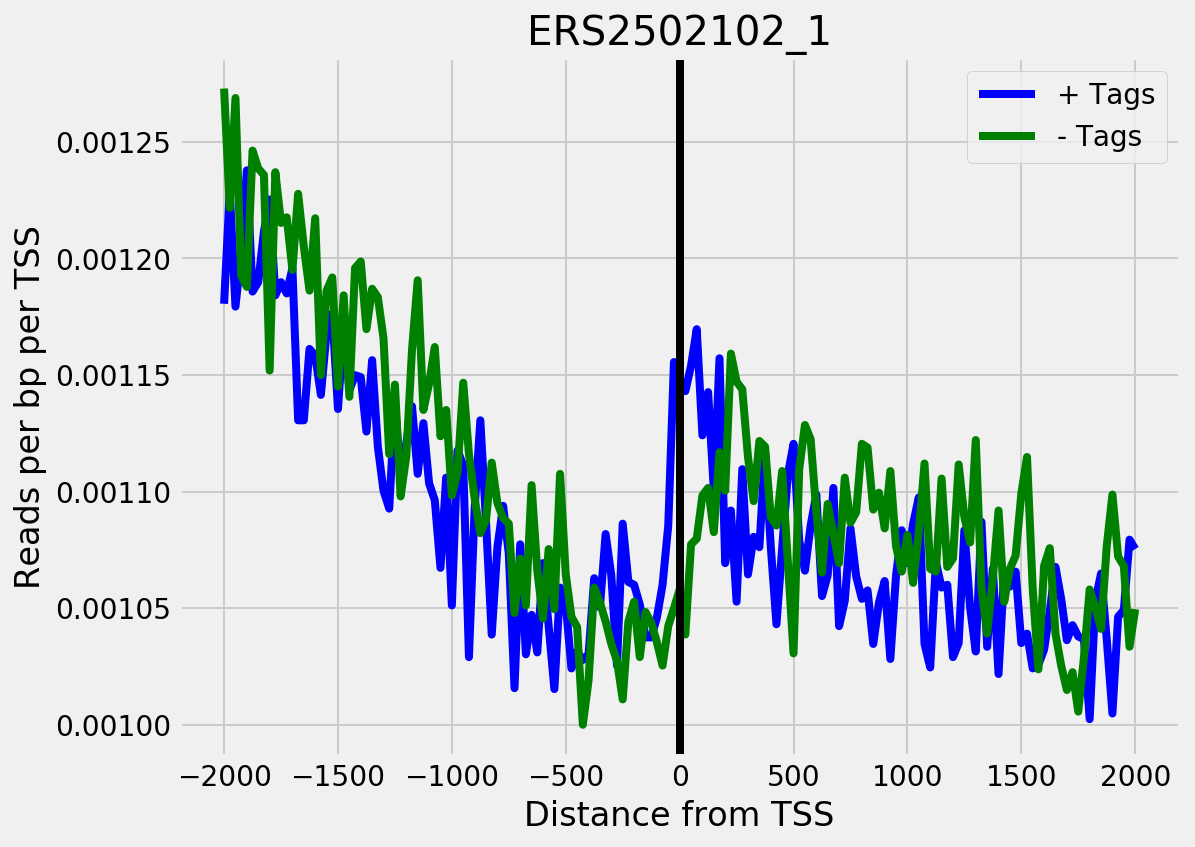

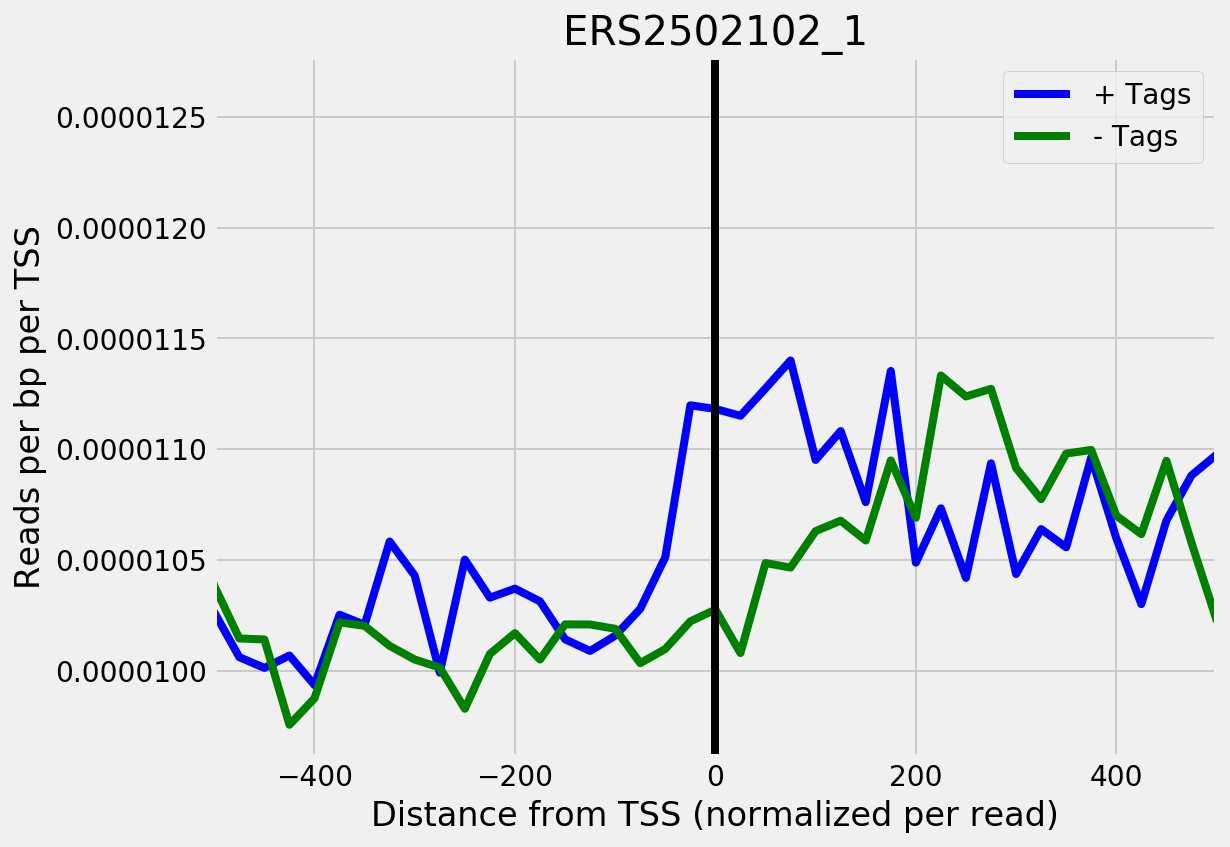

In [ ]:
tag_files = glob.glob(tag_dir + "/*")

for tag_f in tag_files:
    save_f = os.path.join(epi_hist_dir, os.path.basename(tag_f) + "_hist")
    if len(glob.glob(tag_files[0] + "/*genome.tags.tsv")) > 0:
        hist(tag_f,save_f
             ,ref_fa,anno_gff,mode='peak',peak=bed_f,region=4000,res=25,pc=3,
            include_norm=True, include_heat=True)
        label = design[design["ID"] == os.path.basename(tag_f).replace("_1","")]["group"].values[0] + " " + os.path.basename(tag_f).replace("_1","")
        hist_plot(save_f, xlim=None, label=os.path.basename(tag_f))

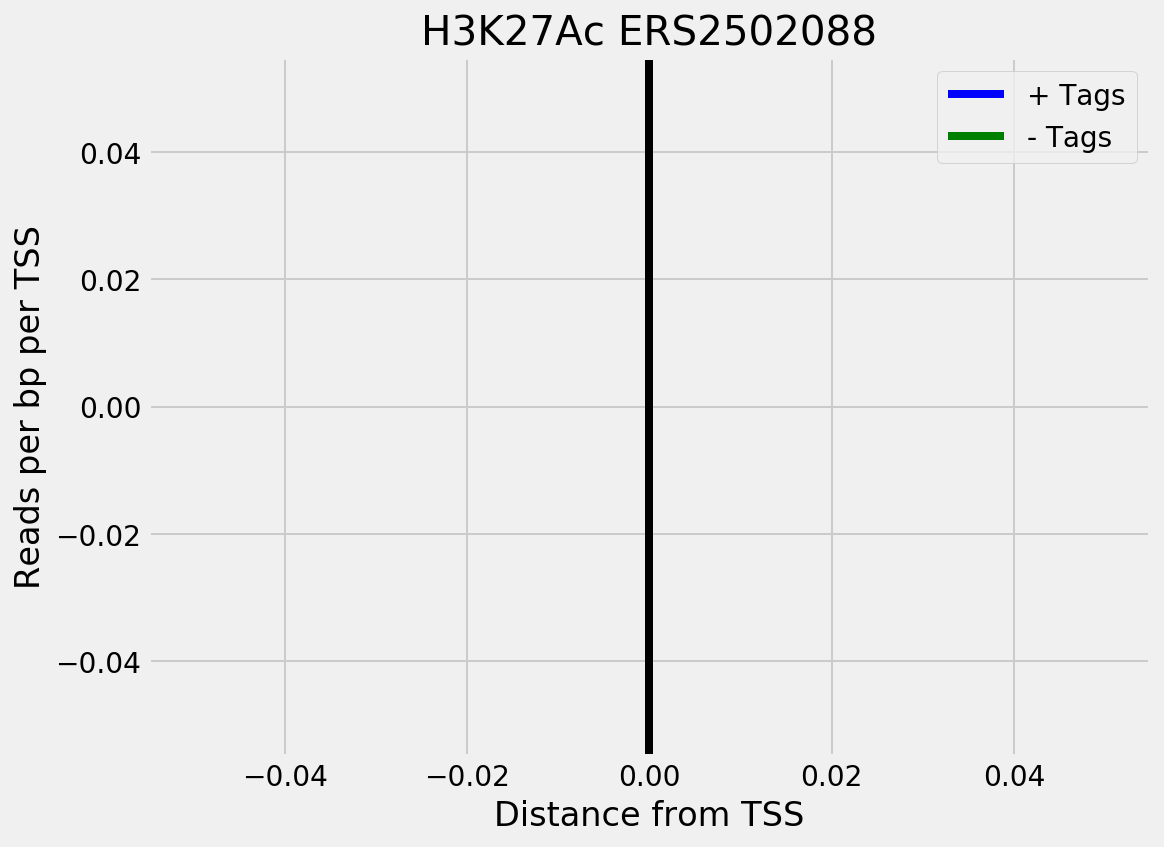

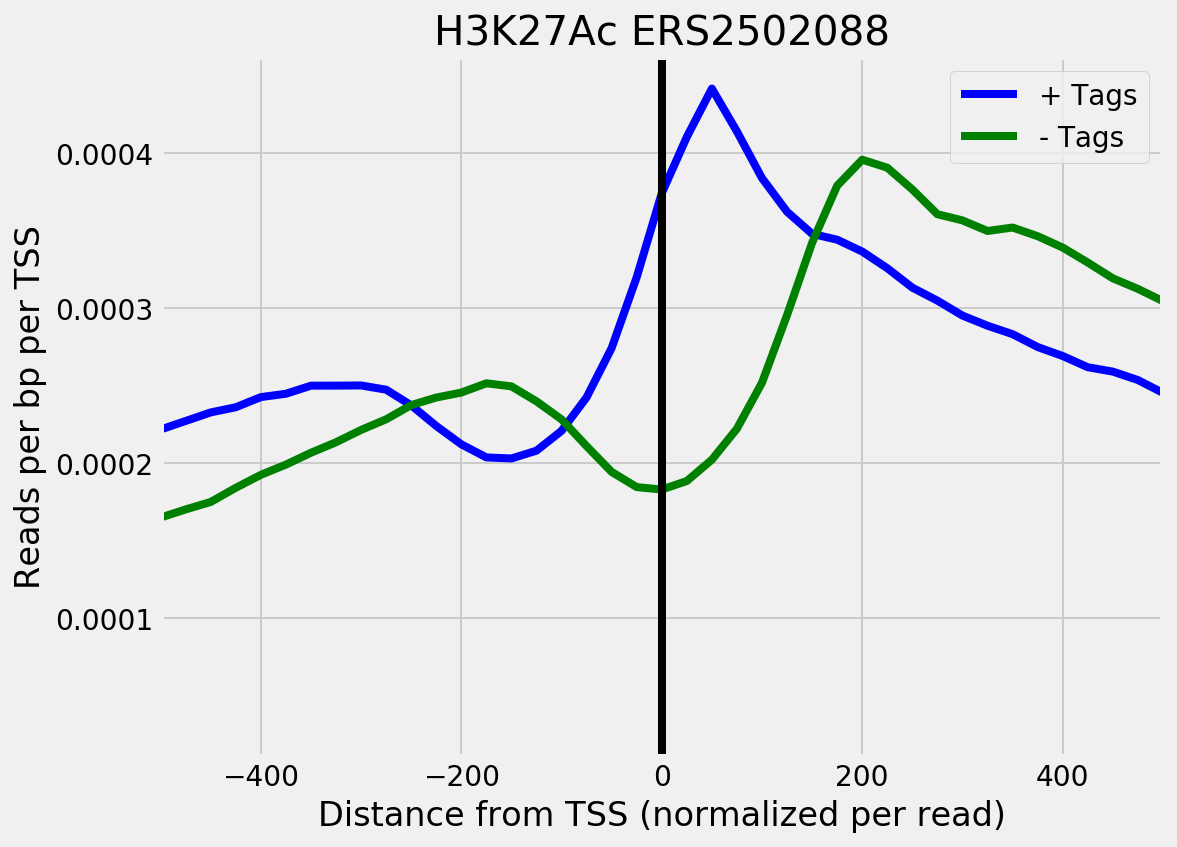

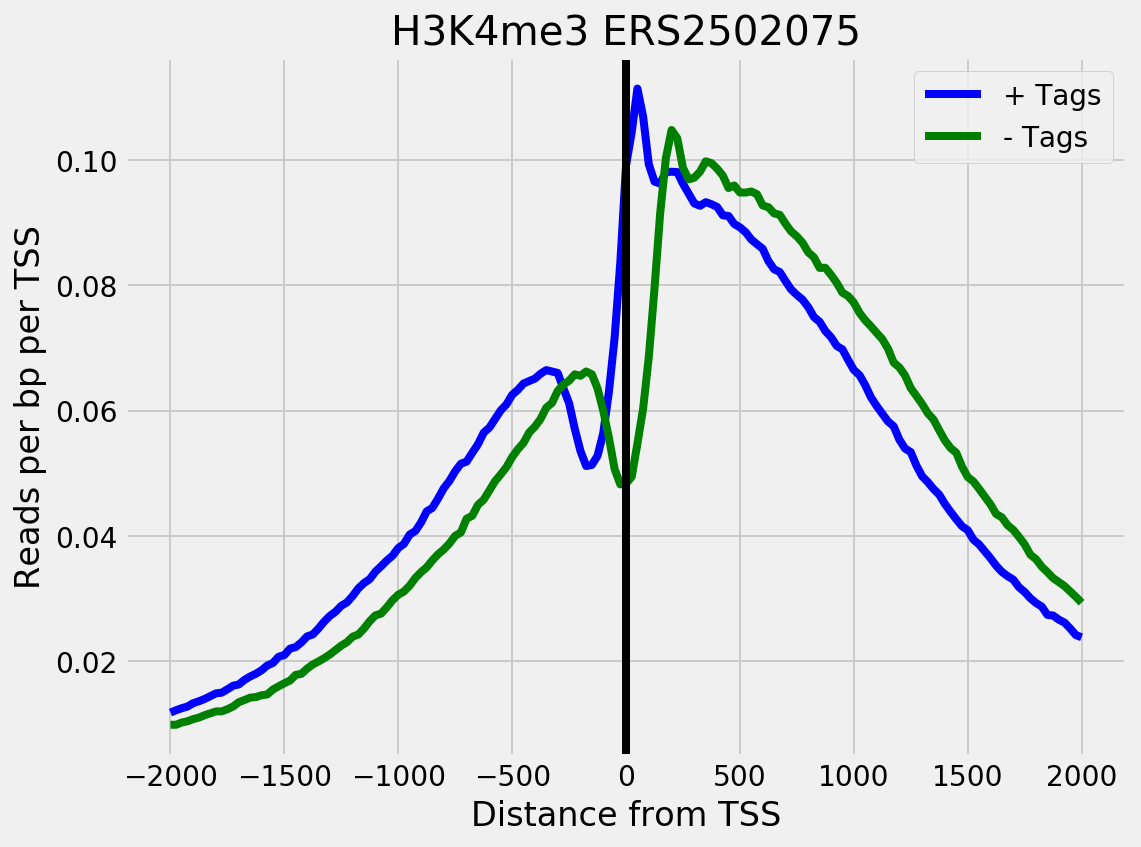

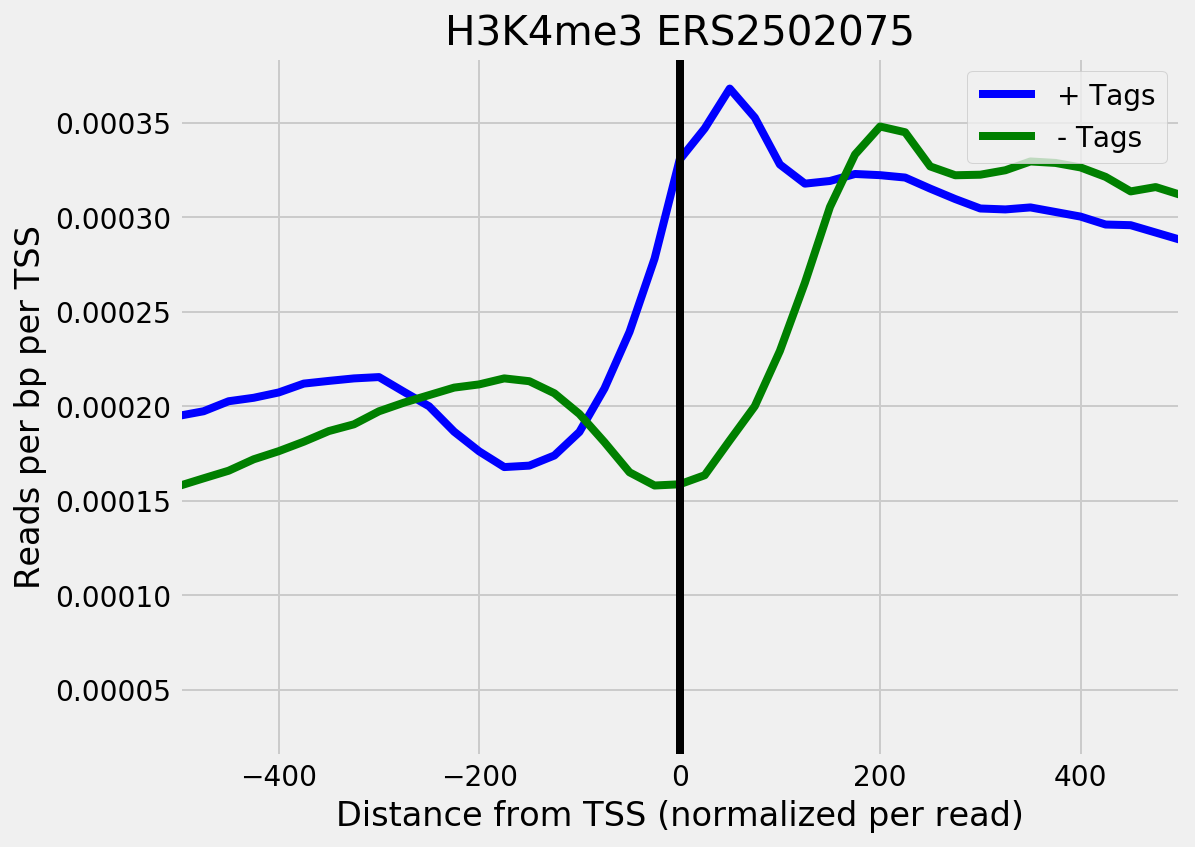

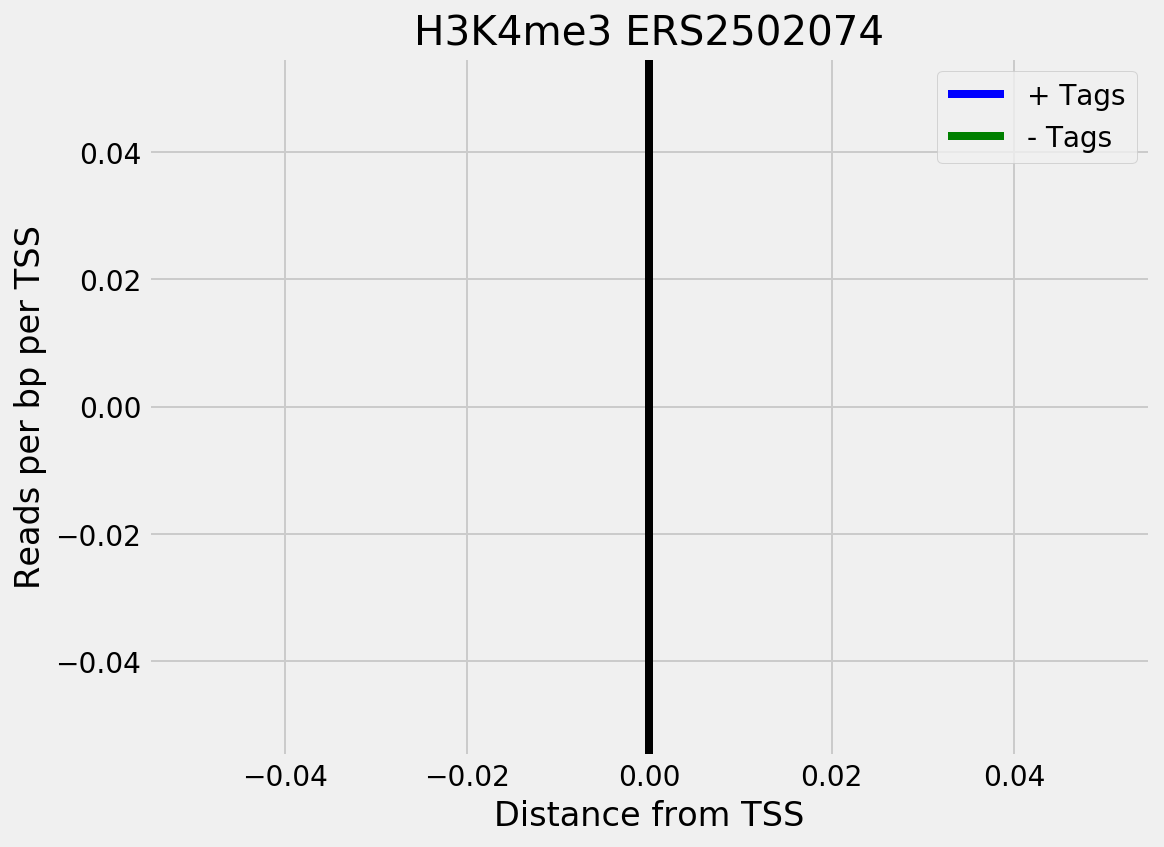

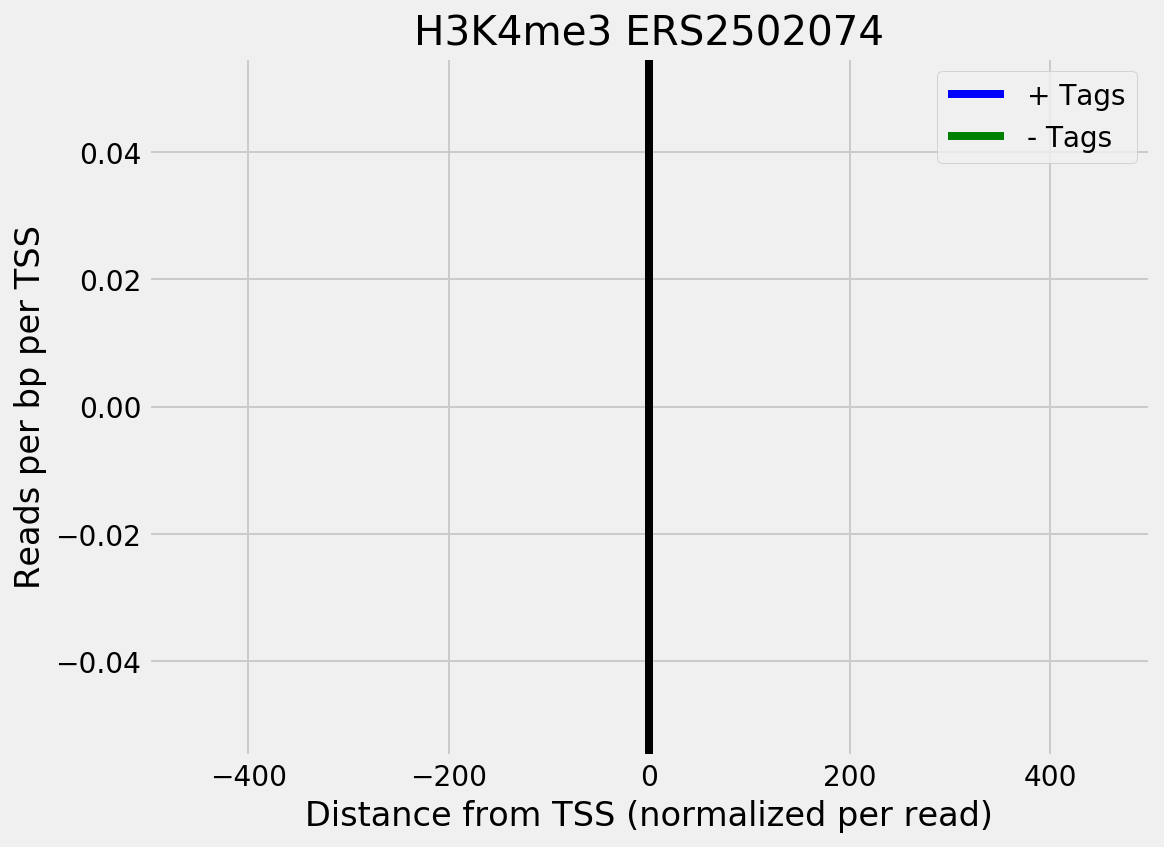

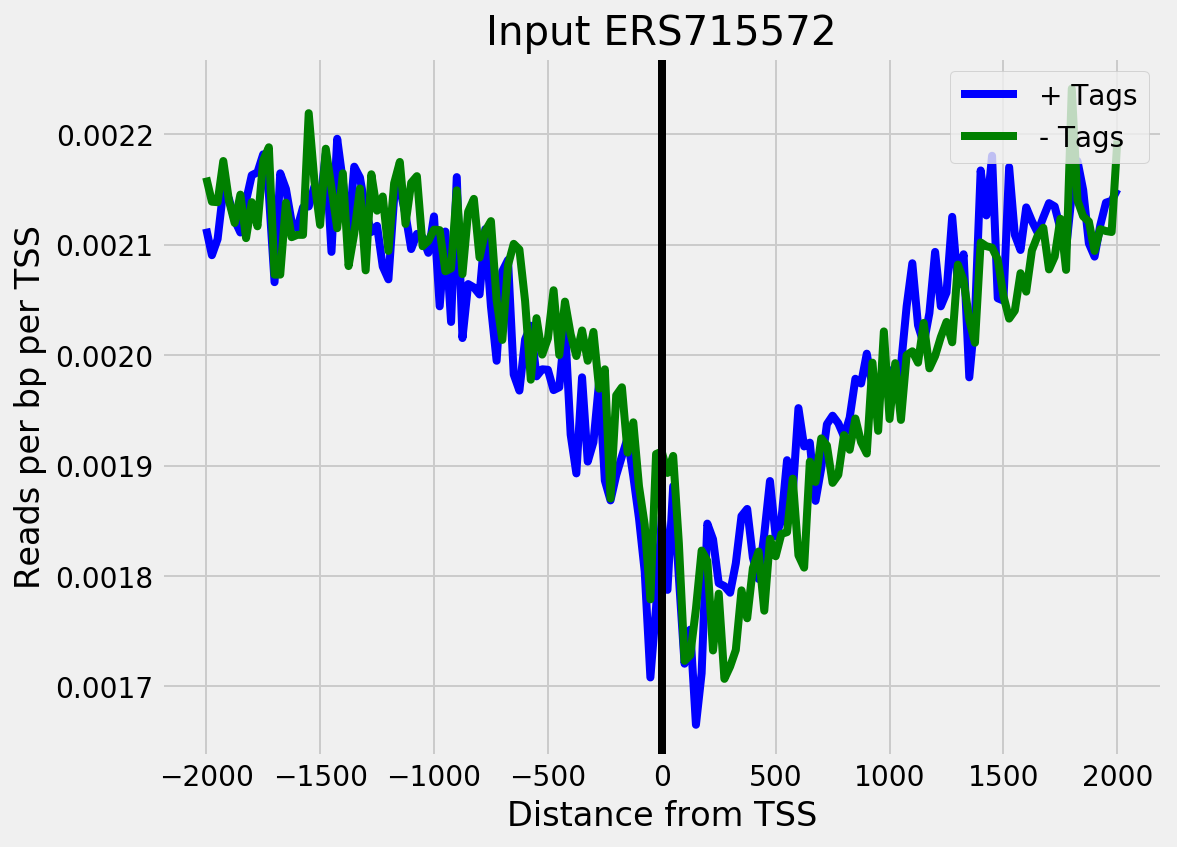

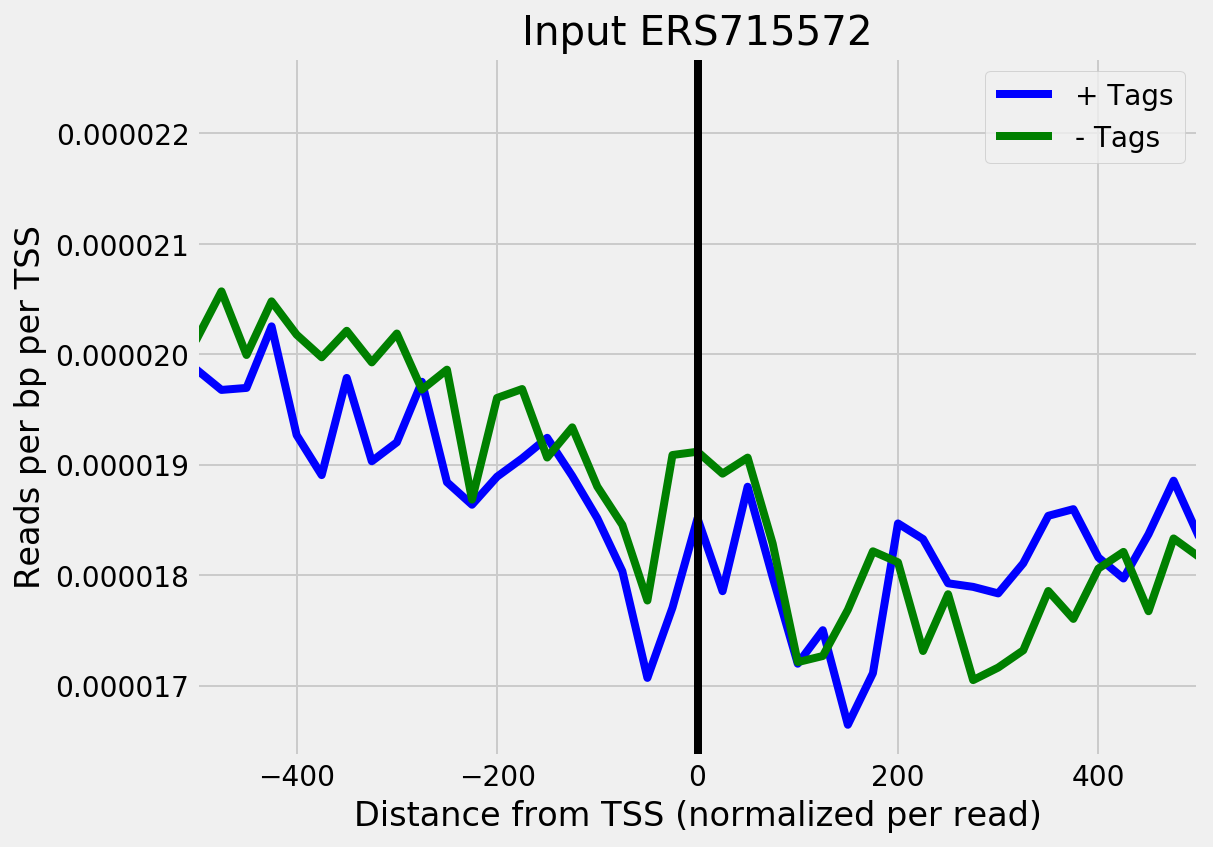

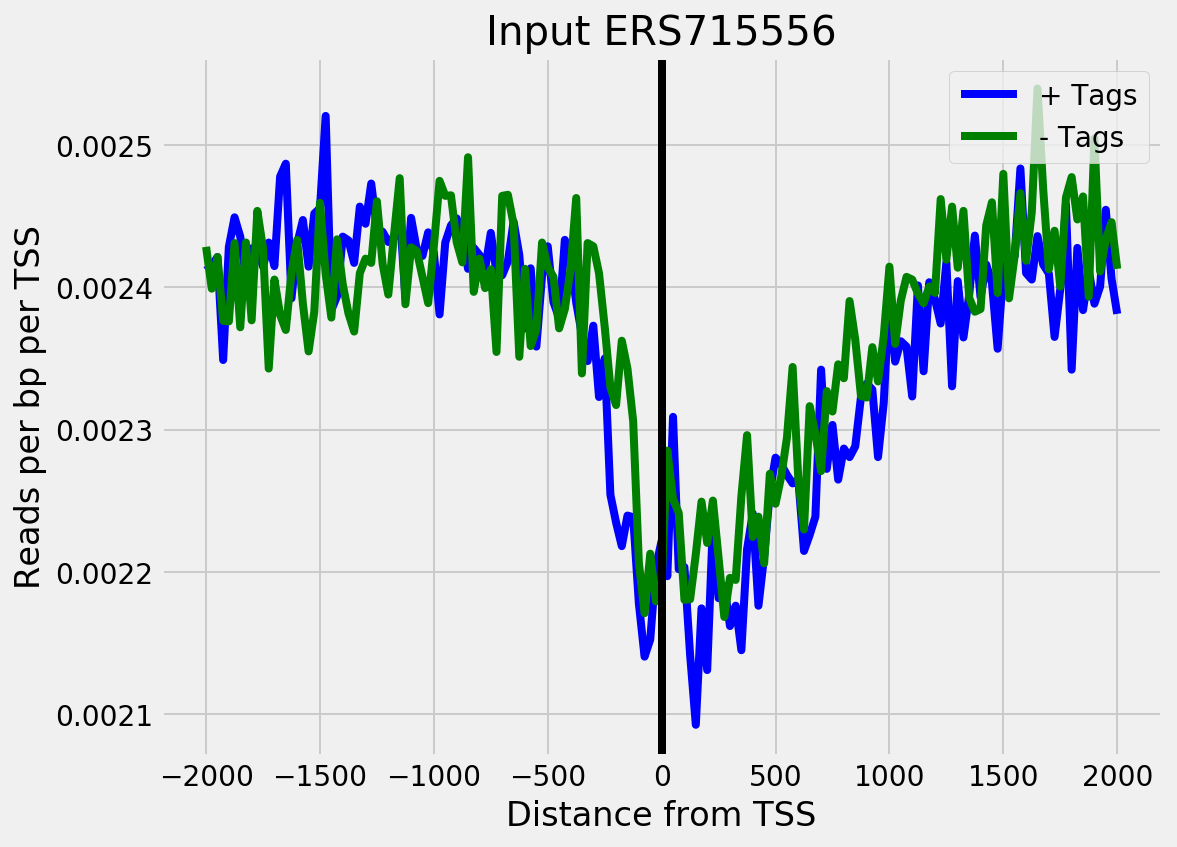

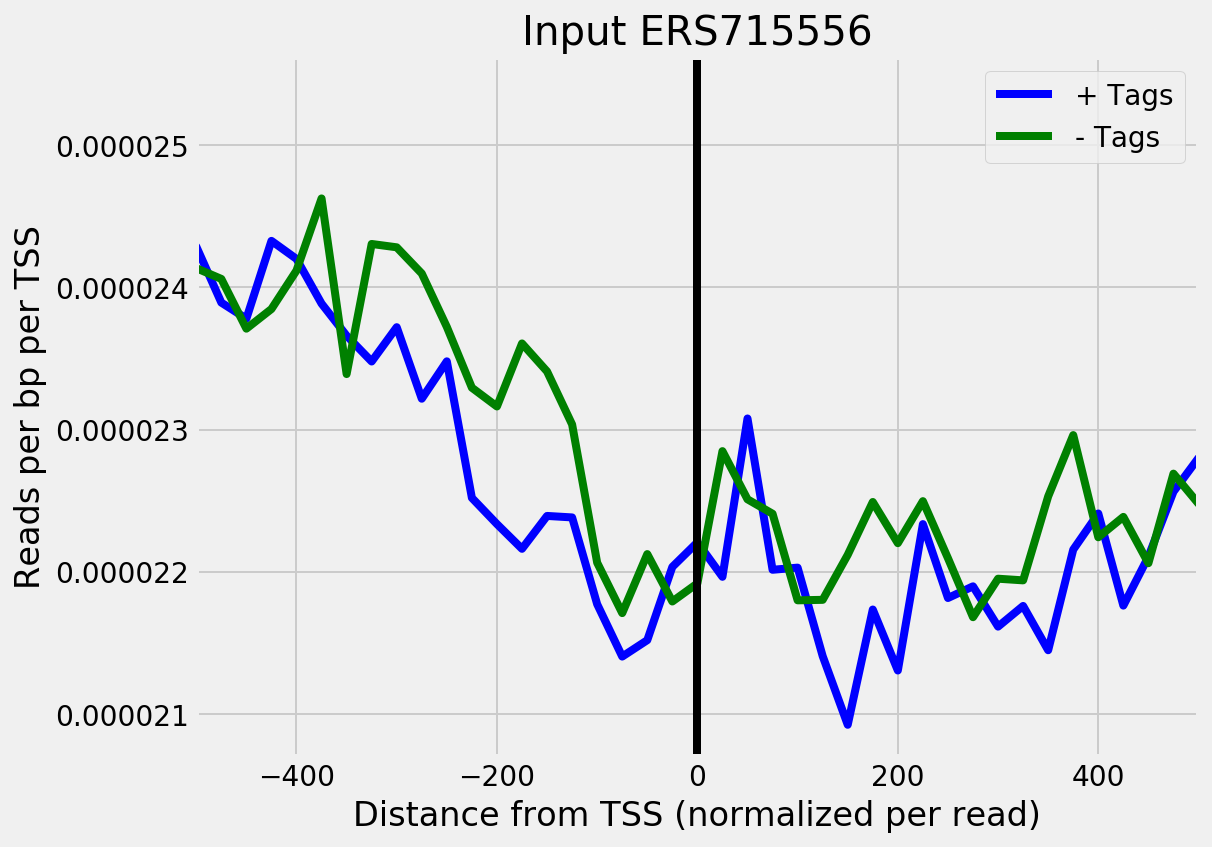

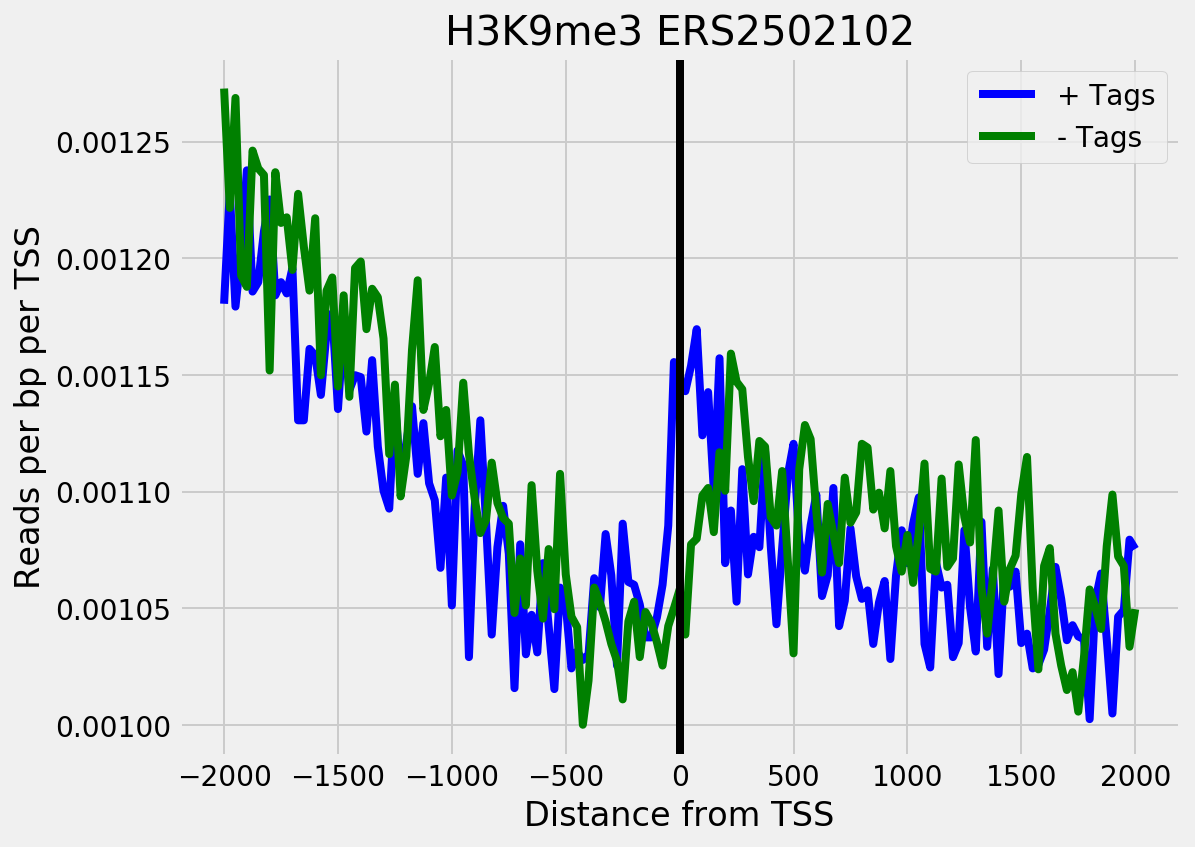

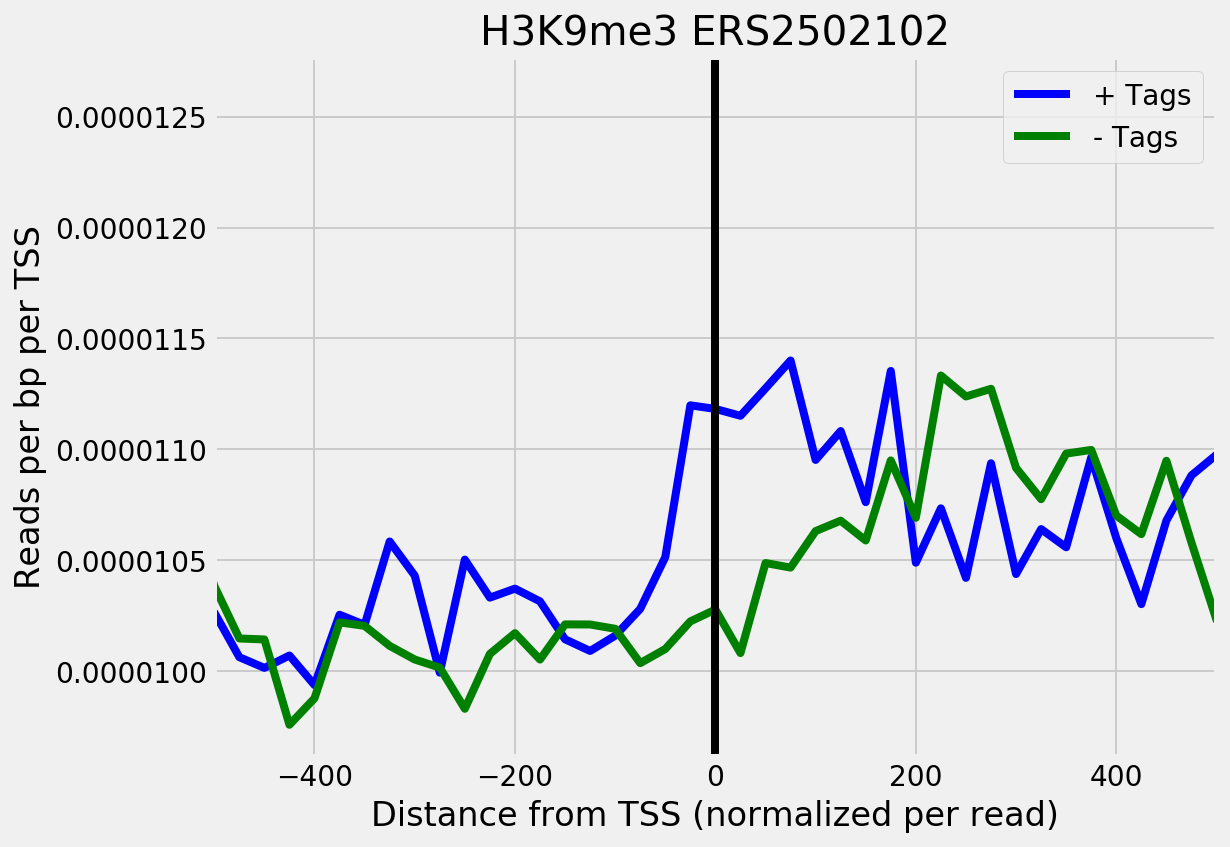

In [16]:
for tag_f in tag_files:
    save_f = os.path.join(epi_hist_dir, os.path.basename(tag_f) + "_hist")
    if len(glob.glob(tag_files[0] + "/*genome.tags.tsv")) > 0:
        label = design[design["ID"] == os.path.basename(tag_f).replace("_1","")]["group"].values[0] + " " + os.path.basename(tag_f).replace("_1","")
        hist_plot(save_f, xlim=None, label=label)

In [ ]:
inputs = (design[design["group"] == "Input"]["fastq_1"].apply(lambda x: x.split(".fastq.gz")[0]))
inputs = " ".join(map(lambda x: os.path.join(tag_dir, x+"_1") , inputs))

for ind, val in design[design["group"] != "Input"].groupby("group"):
    
    #print(val)
    tags = " ".join(val["fastq_1"].apply(lambda x: os.path.join(tag_dir, x.split(".fastq.gz")[0] + "_1")))
    
    curr_out = os.path.join(peak_dir, ind)
    cmd = "findPeaks -style histone -t {tags}  -i {inputs} > {curr_out}".format(tags=tags, inputs=inputs,
                                                                                        curr_out=curr_out)
    print(cmd)

    cmd = "getDifferentialPeaksReplicates.pl -style histone -t {tags}  -i {inputs} > {curr_out}".format(tags=tags, inputs=inputs,
                                                                                        curr_out=curr_out)
    print(cmd)

findPeaks -style histone -t /data/isshamie/TSS/NCBI_PICR_103_Processed/external/Sequencing/PRJEB9291/processed/tagDir/ERS2502089_1 /data/isshamie/TSS/NCBI_PICR_103_Processed/external/Sequencing/PRJEB9291/processed/tagDir/ERS2502088_1  -i /data/isshamie/TSS/NCBI_PICR_103_Processed/external/Sequencing/PRJEB9291/processed/tagDir/ERS715556_1 /data/isshamie/TSS/NCBI_PICR_103_Processed/external/Sequencing/PRJEB9291/processed/tagDir/ERS715572_1 /data/isshamie/TSS/NCBI_PICR_103_Processed/external/Sequencing/PRJEB9291/processed/tagDir/ERR868163_1 > /data/isshamie/TSS/NCBI_PICR_103_Processed/external/Sequencing/PRJEB9291/processed/peaksDir/H3K27Ac
getDifferentialPeaksReplicates.pl -style histone -t /data/isshamie/TSS/NCBI_PICR_103_Processed/external/Sequencing/PRJEB9291/processed/tagDir/ERS2502089_1 /data/isshamie/TSS/NCBI_PICR_103_Processed/external/Sequencing/PRJEB9291/processed/tagDir/ERS2502088_1  -i /data/isshamie/TSS/NCBI_PICR_103_Processed/external/Sequencing/PRJEB9291/processed/tagDir/ER

In [ ]:
print